### Step by step design
1. Simulate Rankings of Relevance E and P
2. Calculate delta ERR
3. Implement Team-Draft (5pts) and Probabilistic Interleaving (35pts)
4. Simulate User Clicks (40pts)
5. Simulate Interleaving Experiment
6. Compute Sample Size
7. Analysis (20pts)

Homework description: https://docs.google.com/document/d/1sNat5t1asD6Jj7eCSWo_9esHoFYWrw9wjwE3kMdgMxc/edit#



In [2]:
import numpy as np
import itertools
import random as rnd
import math
from copy import deepcopy
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
CUT_OFF_RANK = 3
ranking_scale = range(2)

In [38]:
# Simulate all pairs of E and P
ranking_results = list(itertools.product(ranking_scale, repeat=CUT_OFF_RANK))
all_pairs = list(itertools.product(ranking_results, repeat=2))

In [5]:
############# CALCULATE ERR #############

def rel_grade_to_prob(grade):
    #map relevance grade to probability
    R_i = (2**grade)-1 / 2**(np.amax(ranking_scale))
    return R_i


def compute_err(ranked_results):
    #According to Algorithm 2 in ERR-paper
    err = 0    
    for r in range(1,CUT_OFF_RANK+1):        
        R_r = rel_grade_to_prob(ranked_results[r-1])
        for i in range(1,r):
            R_i = rel_grade_to_prob(ranked_results[i-1])
            R_r = R_r * (1-R_i)        
        err += R_r / r
        
    return err

In [32]:
# Create lookup table for ranked_results - ERR
dict_results_err = {}
for ranked_list in ranking_results:
    dict_results_err[ranked_list] = compute_err(ranked_list)
    


In [33]:
# Creating the bins for delta ERR
lower_bonds = np.round(np.linspace(0,1,num=10, endpoint=False), decimals=2)
lower_bonds[0] = 0.05
upper_bonds = np.round(np.linspace(0.1,1,num=10), decimals=2)
upper_bonds[-1] = 0.95
bins = list(zip(lower_bonds, upper_bonds))


In [41]:
############# CALCULATE DELTA ERR #############

#Compute delta ERR
dict_rel_pairs = {}
for upper in upper_bonds:
    dict_rel_pairs[upper] = []
all_delta_err = []
rel_delta_err = []

for pair in all_pairs:    
    #compute delta ERR   
    delta_err = dict_results_err[pair[0]] - dict_results_err[pair[1]]    
    #add pair to corresponding group if E outperforms P
    if delta_err > lower_bonds[0]:        
        for bond in upper_bonds:            
            if delta_err < bond:                
                dict_rel_pairs[bond].append(pair)                
                rel_delta_err.append(delta_err)                
                break

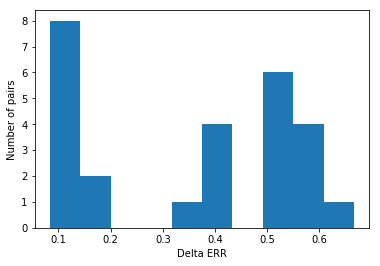

In [11]:
# Distribution of delta ERR over the bins
plt.hist(rel_delta_err, bins=10)
plt.ylabel("Number of pairs")
plt.xlabel("Delta ERR")

In [12]:
# add document numbers which allow that the documents returned can be distict but also can overlap
# we considered there are 30 distinct documents in the collection D
# we need these numbers for correctly computing Team-Draft/Probabilistic Interleaving
def assign_doc_labels(pair):
    labeled_pair = []
    for ranked_list in pair:
        doc_labels = []
        docs_l = rnd.sample(range(1, 30), 3)        
        for i in docs_l:
            #generate doc labels
            doc_labels.append("d{0}".format(i))
            
        labeled_pair.append(list(zip(doc_labels,ranked_list)))
    return labeled_pair

In [13]:
# TEAM-DRAFT INTERLEAVING

# function which deletes a document from a list of documents
def remove_document_from_list(d, d_list):    
    for doc in d_list:        
        if d[0] == doc[0]:
            d_list.remove(doc)
            break

# function which computes the interleaved list based on Team-Draft approach
def team_draft_interleaving(pair, max_length=3):
    
    labeled_pair = assign_doc_labels(pair) # list(doc_id , relevance_grade)
    teams = {"E": list(labeled_pair[0]), "P": list(labeled_pair[1])}
    interleaved_list = []
    team_E = 0
    team_P = 0   
    
    while(len(interleaved_list) < max_length):        
        if team_E < team_P:
            chosen_team = 'E'                  
            chosen_doc = teams['E'].pop(0)
            team_E += 1
            remove_document_from_list(chosen_doc,teams['P'])
        elif team_E > team_P:
            chosen_team = 'P'                    
            chosen_doc = teams['P'].pop(0)
            team_P += 1
            remove_document_from_list(chosen_doc,teams['E'])
        elif team_E == team_P:
            chosen_team = rnd.choice(list(teams.keys()))        
            chosen_doc = teams[chosen_team].pop(0)
            if chosen_team == 'E':               
                team_E += 1
                remove_document_from_list(chosen_doc,teams['P'])
            else:             
                team_P += 1
                remove_document_from_list(chosen_doc,teams['E'])                
                
        interleaved_list.append((chosen_team,chosen_doc[1]))        

    return interleaved_list

In [34]:
# PROBABILISTIC INTERLEAVING

def inverse_power(x, power):
    return 1/(x**power)

def softmax_probabilities(num_ranks, tau=3):
    #Following formula (1) from Probabilistic Interleaving paper
    softmax_probs = []
    ranks = range(1, num_ranks+1)
    denominator = sum(list(inverse_power(r,tau) for r in ranks))    
    for rank in ranks:
        softmax_probs.append(inverse_power(rank,tau)/denominator)
    
    return softmax_probs

# Function which computes the interleaved list based on Probabilistic approach 
def probabilistic_interleaving(pair, max_length=3):
    interleaved_list = []
    labeled_pair = assign_doc_labels(pair) # list(doc_id , relevance_grade)
    teams = {"E": list(labeled_pair[0]), "P": list(labeled_pair[1])}
    
    while(len(interleaved_list) < max_length):
        chosen_team = rnd.choice(list(teams.keys()))
        if chosen_team == 'E':
            other_team = 'P'
        else:
            other_team = 'E'            
        chosen_list = teams[chosen_team]        
        
        softmax_samples = softmax_probabilities(len(chosen_list))
        uni_sample = np.random.uniform(low=0.0, high=1.0)
        threshold = 0
        #select doc from list with respect to probabilities
        for prob in softmax_samples:
            threshold += prob            
            if uni_sample < threshold:                
                chosen_doc = chosen_list.pop(softmax_samples.index(prob))
                remove_document_from_list(chosen_doc,teams[other_team])            
                interleaved_list.append((chosen_team,chosen_doc[1]))                  
                break               
    
    return interleaved_list

In [36]:
# POSITION-BASED CLICK MODEL   
cut_off = 3

# reading the document and creating the dictionaries for storing the relevant data
f = open('YandexRelPredChallenge.txt','r')
d_query = {}
d_doc_for_query = {}
i = 0
for line in f:   
    l = line.split()    
    
    if(l[2] == 'Q'):
        if(l[3] not in d_query.keys()):
            d_query[l[3]] = []
            d_doc_for_query[l[3]] = []
        
        d_doc_for_query[l[3]] = list(set().union(d_doc_for_query[l[3]],l[5:5+cut_off]))
        d_query[l[3]].append([])
        
        urls = l[5:5+cut_off]
        d_query[l[3]][len(d_query[l[3]]) - 1].append(urls)
        d_query[l[3]][len(d_query[l[3]]) - 1].append([])
        
        last_query = l[3]
    
    else:
        if l[3] in d_query[last_query][len(d_query[last_query]) - 1][0]:
            d_query[last_query][len(d_query[last_query]) - 1][1].append(l[3])            



In [35]:
# computing the total number of sessions in the document
def session_number(d_query):
    sess_nr = 2
    for query in d_query.keys():
        sess_nr += len(d_query[query])
    return sess_nr

sess_nr = session_number(d_query)

In [22]:
# EM algorithm for Position-Based Model
# calculates the values of alphas and gammas
def position_based_model():                
    # initialize alphas
    alpha_q_u = {}
    for query in d_doc_for_query.keys():
        for doc in d_doc_for_query[query]:
            alpha_q_u[query+'_'+doc] = rnd.uniform(0,1)
    # initialize gammas
    gamma_r = {}
    for i in range(cut_off):
        gamma_r[str(i+1)] = rnd.uniform(0,1)


    T = 100

    for t in range(T):
        # gammas update at iteration t 
        old_gamma_r = deepcopy(gamma_r)
        
        suma = [1]*cut_off
        for q in d_query.keys():
            for s,c in d_query[q]:
                for i in range(cut_off):
                    if s[i] in c:
                        suma[i] += 1
                    else:
                        alpha_key = q + '_' + s[i]
                        suma[i] += (gamma_r[str(i+1)]*(1 - alpha_q_u[alpha_key]))/(1 - (gamma_r[str(i+1)]*alpha_q_u[alpha_key]))

        for i in range(cut_off):
            gamma_r[str(i+1)] = suma[i]/sess_nr

        # alphas update at iteration t
        for q in d_doc_for_query.keys():
            for u in d_doc_for_query[q]:
                alpha_key = q + '_' + u

                suma1 = 1
                S_u_q = 2

                for s,c in d_query[q]:
                    if u in s:
                        S_u_q += 1                    
                        if u in c:
                            suma1 += 1
                        else:
                            index = s.index(u) 
                            suma1 += ((1 - old_gamma_r[str(index+1)])*alpha_q_u[alpha_key])/(1 - (old_gamma_r[str(index+1)]*alpha_q_u[alpha_key]))

                alpha_q_u[alpha_key] = suma1/S_u_q
        
    return gamma_r

In [23]:
# Getting gamma values
gamma_r = position_based_model()
print(str(gamma_r['1']) + ' ' + str(gamma_r['2']) + ' ' + str(gamma_r['3']))

0.9994884959352852 0.48277833113743346 0.33363043278882926


In [39]:
#################    GETTING THE PROBABILITIES FROM PBM/RCM ###################

# Function wich computes the probabilities based on gammas from PBM and epsilon
def position_based_model_probs(ranked_list, epsilon = 0.1):
    probs = []
    r = 1
    for _, rel in ranked_list:
        if rel == 1:
            probs.append((1-epsilon)*gamma_r[str(r)])
        else: 
            probs.append(epsilon*gamma_r[str(r)])
        r += 1
    return probs
  
# Function which calculates the total number of clicks used to compute rho for Random Click Model
def click_number(d_query):    	
    click_nr = 0
    for query in d_query.keys():
        for s,c in d_query[query]:
            click_nr += len(c)
    return click_nr

# Computing the probabilities for Random Click Model
def random_click_model_probs():
    rho = click_number(d_query)/(session_number(d_query)*CUT_OFF_RANK)
    return [rho]*CUT_OFF_RANK


In [40]:
##################### SIMULATION OF USER CLICKS #########################

# Function which simulates the user clicks based on probabilities given by PBM/RCM
def sim_clicks(ranked_list, probs, epsilon = 0.1):
    clicks = []
    for r in range(CUT_OFF_RANK): 
        ran = rnd.uniform(0,1)
        if probs[r] < ran:
            clicks.append(1)
        else: 
            clicks.append(0)
    return clicks

# Function which calculates the winner system of a click simulation
def winner(interleaved_list, probs, epsilon = 0.1):
    clicks = sim_clicks(interleaved_list, probs, epsilon = 0.1)
    wins_E = 0
    wins_P = 0
    r = 0
    for alg, _ in interleaved_list:
        if clicks[r] == 1:
            if alg == 'E':
                wins_E += 1
            else:
                wins_P += 1
        r += 1
    if wins_E > wins_P:
        return 1
    elif wins_E < wins_P:
        return -1
    return 0


# interleaving: 0 - Team_Draft,           1 - Probabilistic
# click_model:  0 - Position-Based-Model, 1 - Random-Click-Model

# Function which calculates the percentage of wins of system E
def simulation(pair, interleaving, click_model, rho, K = 10000, epsilon = 0.1):
    if interleaving  == 0:
        interleaved_list = team_draft_interleaving(pair, CUT_OFF_RANK)
    else:
        interleaved_list = probabilistic_interleaving(pair, CUT_OFF_RANK)

    if click_model == 0:
        probs = position_based_model_probs(interleaved_list,epsilon)
    else:
        probs = rho  

    wins_E = 0
    wins_P = 0
    
    for k in range(K):
        if winner(interleaved_list, probs, epsilon) == 1:
            wins_E += 1
        elif winner(interleaved_list, probs, epsilon) == -1:
            wins_P += 1
 
    if (wins_E + wins_P) != 0:
        return wins_E/(wins_E + wins_P)
    return 0


# Function which computes sample size from p value, alpha(0.05) and beta(0.10)
def sample_size(p):
    z = norm.ppf(0.95)*math.sqrt(0.5*0.5) + norm.ppf(0.90)*math.sqrt(p*(1-p))
    if z == 0.0 or p == 0.5:
        return -1
    else:
        return ((z/(abs(p-0.5)))**2) + 1/abs(p-0.5)


In [27]:
#################   FILL THE TABLES  #################

# Function which computes min, median, max sample size values for a bin
def bin_min_median_max(err_bin, interleaving, click_model, K = 100, epsilon = 0.1, M = 1000):
    rho = random_click_model_probs()
    bin_sample_sizes = []
    for pair in err_bin:
        for m in range(M):
            p = simulation(pair, interleaving, click_model, rho, K , epsilon)
            #print(p)
            n = sample_size(p)
            if n != -1:
                bin_sample_sizes.append(n)    
    
    average = np.round(np.mean(bin_sample_sizes))
    mini = min(bin_sample_sizes)
    std_values = []
    for val in bin_sample_sizes:
        if (val >= mini) and (val <= (average + average - mini)):
            std_values.append(val)
            
    std = np.std(std_values)    
    plt.hist(bin_sample_sizes, bins=range(0,100,3))
    return np.round(average - std), average, np.round(average + std)

# Function witch computes the values for all bins
def fill_table(all_bins, interleaving , click_model, K = 100, epsilon = 0.1, M = 1000):
    table = {}
    for bin_key in all_bins.keys():
        if len(all_bins[bin_key]) > 0:
            table[bin_key] = list(bin_min_median_max(all_bins[bin_key],interleaving,click_model,K, epsilon ,M))
            
    return table

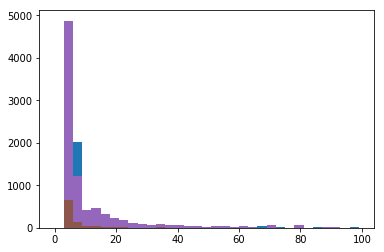

In [28]:
# Team-draft Interleaving with Position-Based Click Model
table_0_0 = fill_table(dict_rel_pairs, 0 , 0, K = 100, epsilon = 0.1, M = 1000)

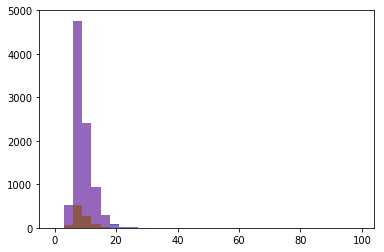

In [29]:
# Team-draft Interleaving with Random Click Model
table_0_1 = fill_table(dict_rel_pairs, 0 , 1, K = 100, epsilon = 0.1, M = 1000)

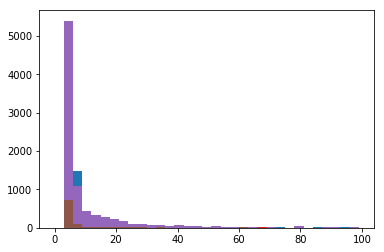

In [30]:
# Probabilistic Interleaving with Position-Based Click Model
table_1_0 = fill_table(dict_rel_pairs, 1 , 0, K = 100, epsilon = 0.1, M = 1000)

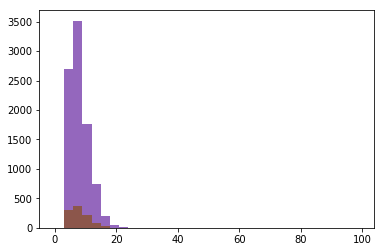

In [31]:
# Probabilistic Interleaving with Random Click Model
table_1_1 = fill_table(dict_rel_pairs, 1 , 1, K = 100, epsilon = 0.1, M = 1000)

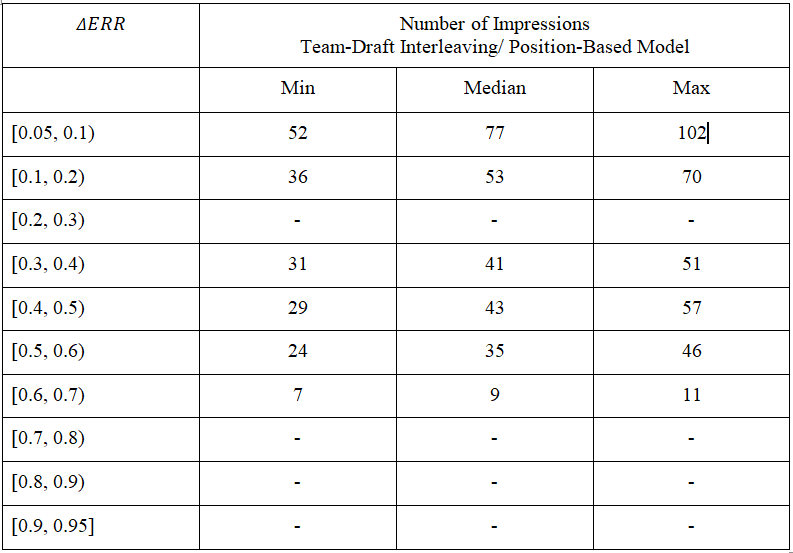


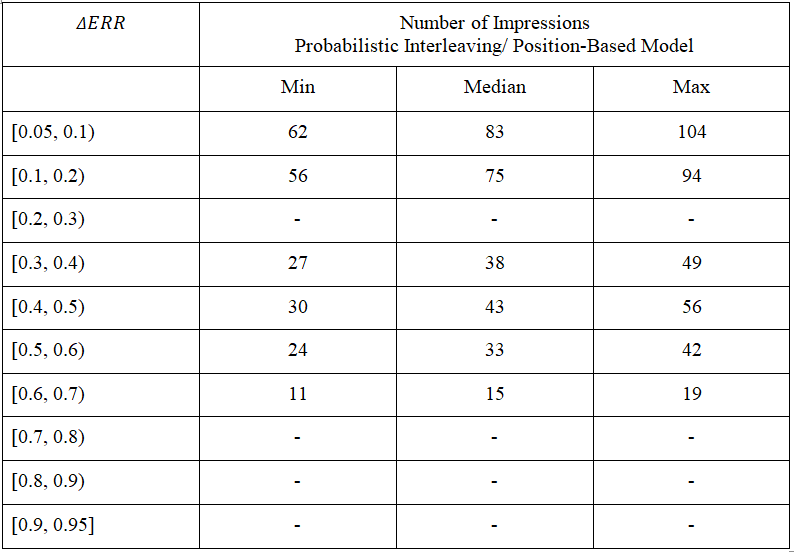

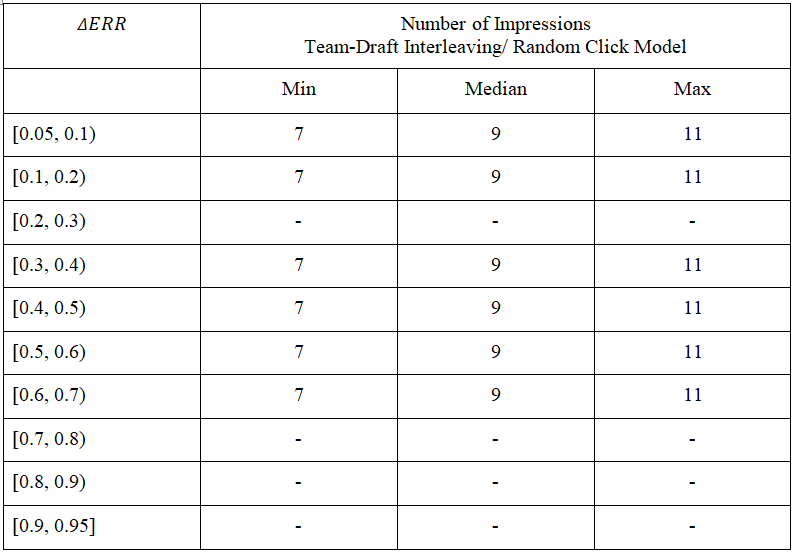

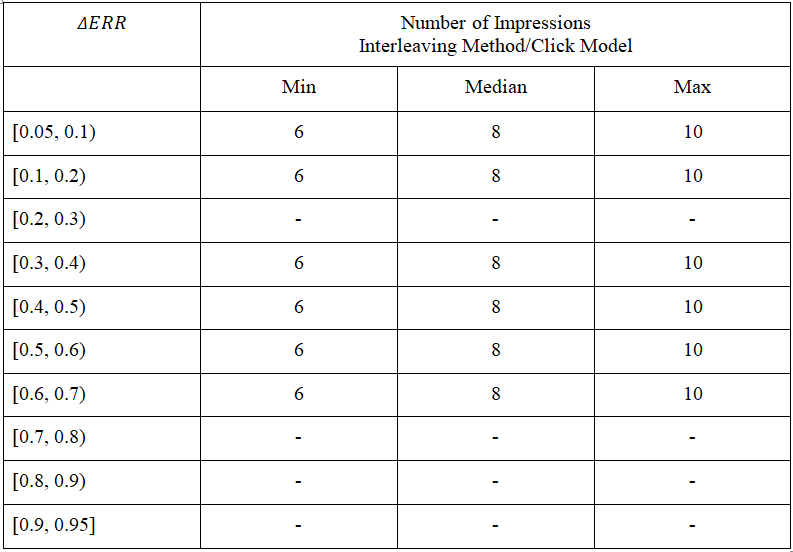